# Proyek Recommendation System : Microsoft News Recommendation Dataset (MIND)
- **Nama:** Atifa Fiorenza
- **Email:** atifafiorenza24@gmail.com
- **ID Dicoding:** atifafiorenza24

## Import Library
Kita perlu mengimpor beberapa library yang akan digunakan dalam pra-pemrosesan data, manipulasi data, dan pemodelan.

In [1]:
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 37.0 MB/s eta 0:00:00


In [2]:
import os
import ast
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

import nltk
# Mengunduh data yang dibutuhkan
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.neighbors import NearestNeighbors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Data Collection
Unduh dataset MIND. Dataset ini berasal dari UCI Machine Learning dan dapat diunduh di Kaggle.

https://www.kaggle.com/datasets/arashnic/mind-news-dataset/data

In [3]:
from google.colab import files
files.upload()  # Upload file kaggle.json dari lokal

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atifa1110","key":"2972f282815cfd20a65bc10625d79e46"}'}

In [4]:
# Membuat folder .kaggle untuk credentials
!mkdir -p ~/.kaggle

# Menyalin file kaggle.json ke folder .kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Memberikan permission agar kaggle.json dapat digunakan
!chmod 600 ~/.kaggle/kaggle.json

# Mendownload dataset Rice Leaf Diseases dari Kaggle
!kaggle datasets download -d arashnic/mind-news-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/mind-news-dataset
License(s): CC0-1.0
  0% 0.00/61.7M [00:00<?, ?B/s]
100% 61.7M/61.7M [00:00<00:00, 989MB/s]


In [5]:
# Mengekstrak file dataset
!unzip mind-news-dataset.zip -d mind

Archive:  mind-news-dataset.zip
  inflating: mind/MINDsmall_train/behaviors.tsv  
  inflating: mind/MINDsmall_train/entity_embedding.vec  
  inflating: mind/MINDsmall_train/news.tsv  
  inflating: mind/MINDsmall_train/relation_embedding.vec  
  inflating: mind/news.tsv/news.tsv  


## Load Dataset
Load and read news dataset from folder mind

In [6]:
behaviors = '/content/mind/MINDsmall_train/behaviors.tsv'
news = '/content/mind/MINDsmall_train/news.tsv'

Read News Dataset

In [7]:
# Membaca CSV news
df_news = pd.read_csv(news,sep="\t", names=["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"])
df_news.head()

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


> Read Behaviors Dataset

In [8]:
# Membaca CSV behaviors
df_behaviors = pd.read_csv(behaviors, sep='\t',
                         names=["Impression_ID", "User_ID", "Time", "History", "Impressions"])
df_behaviors.head()

,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


## Data Understanding
Pada tahap ini dilihat gambaran awal dataset, meliputi jumlah baris dan kolom, tipe data tiap atribut, serta statistik deskriptif dasar. Selain itu, dicek juga apakah ada nilai yang hilang (null) dan data duplikat.

In [9]:
df_news.shape

(51282, 8)

In [10]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


In [11]:
df_news.describe()

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
count,51282,51282,51282,51282,48616,51282,51279,51278
unique,51282,17,264,50434,47309,51281,34472,36277
top,N44276,news,newsus,Photos of the Day,What's the weather today? What's the weather f...,[],[],[]
freq,1,15774,6564,15,124,2,13842,13825


In [12]:
df_behaviors.shape

(156965, 5)

In [13]:
df_behaviors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Impression_ID  156965 non-null  int64 
 1   User_ID        156965 non-null  object
 2   Time           156965 non-null  object
 3   History        153727 non-null  object
 4   Impressions    156965 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.0+ MB


In [14]:
df_behaviors.describe()

,Impression_ID
count,156965.000000
mean,78483.000000
std,45312.036839
min,1.000000
25%,39242.000000
50%,78483.000000
75%,117724.000000
max,156965.000000


In [15]:
def check_null_and_duplicates(df, name="DataFrame"):
    print(f"======== {name} ========")

    # Cek missing values
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]  # hanya tampilkan kolom dengan null > 0
    if not null_counts.empty:
        print("\nKolom dengan missing values:")
        print(null_counts)
    else:
        print("\nTidak ada missing values.")

    # Cek duplikat
    dup_count = df.duplicated().sum()
    if dup_count > 0:
        print(f"\nJumlah baris duplikat: {dup_count}")
    else:
        print("\nTidak ada duplikat.")

    print("\n")

# Pemanggilan
check_null_and_duplicates(df_news, "News")
check_null_and_duplicates(df_behaviors, "Behaviors")

======== News ========

Kolom dengan missing values:
Abstract             2666
Title_Entities          3
Abstract_Entities       4
dtype: int64

Tidak ada duplikat.


======== Behaviors ========

Kolom dengan missing values:
History    3238
dtype: int64

Tidak ada duplikat.




## Data Exploration

Tahap ini digunakan untuk memahami pola dan distribusi data melalui visualisasi, serta melihat hubungan antar fitur dan kemungkinan adanya outlier.

### Univariate Analysis

Analisis univariat dilakukan untuk melihat distribusi dari setiap fitur secara terpisah. Pada dataset ini, fitur utama yang dianalisis adalah **Category dan SubCategory** untuk mengetahui proporsi berita berdasarkan labelnya. Sementara itu, fitur berbentuk teks seperti **Title dan Abstract dianalisis melalui distribusi panjang kata**, sedangkan **Title_Entities dan Abstract_Entities dilihat dari jumlah entitas yang muncul**. Adapun News_ID berfungsi sebagai identifier sehingga tidak perlu dianalisis distribusinya.

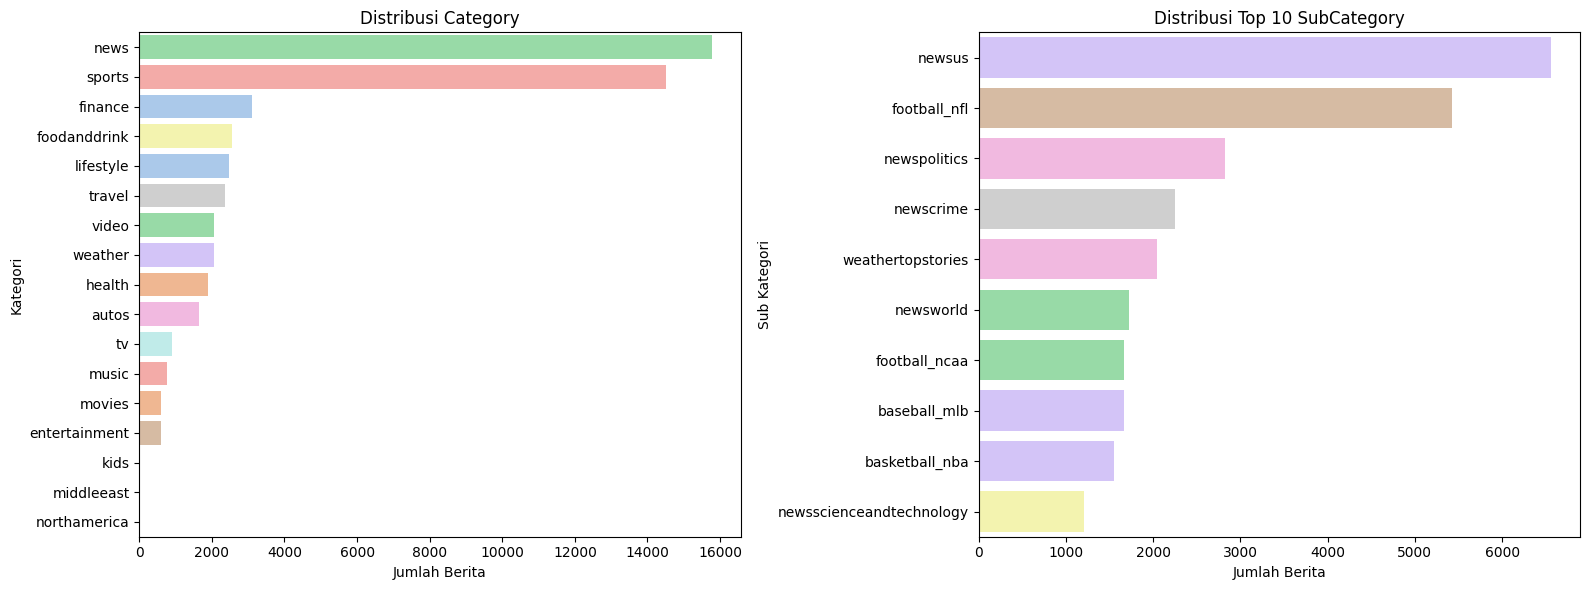

In [16]:
# Buat 2 grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribusi Category
sns.countplot(
    data=df_news,
    y="Category",
    hue="Category",
    order=df_news["Category"].value_counts().index,
    palette="pastel",
    ax=axes[0]
)
axes[0].set_xlabel("Jumlah Berita")
axes[0].set_ylabel("Kategori")
axes[0].set_title("Distribusi Category")
axes[0].legend([],[], frameon=False)  # hapus legend biar ga dobel

# Distribusi SubCategory (Top 10)
sns.countplot(
    data=df_news,
    y="SubCategory",
    hue="SubCategory",
    order=df_news["SubCategory"].value_counts().head(10).index,
    palette="pastel",
    ax=axes[1]
)
axes[1].set_xlabel("Jumlah Berita")
axes[1].set_ylabel("Sub Kategori")
axes[1].set_title("Distribusi Top 10 SubCategory")
axes[1].legend([],[], frameon=False)

plt.tight_layout()
plt.savefig('distribusi_univariate.png')
plt.show()

Dataset sangat didominasi oleh berita news dan sports, dengan subkategori newsus dan football_nfl paling banyak. Ketidakseimbangan distribusi ini penting untuk diperhatikan karena bisa membuat model klasifikasi nanti lebih condong ke kategori mayoritas

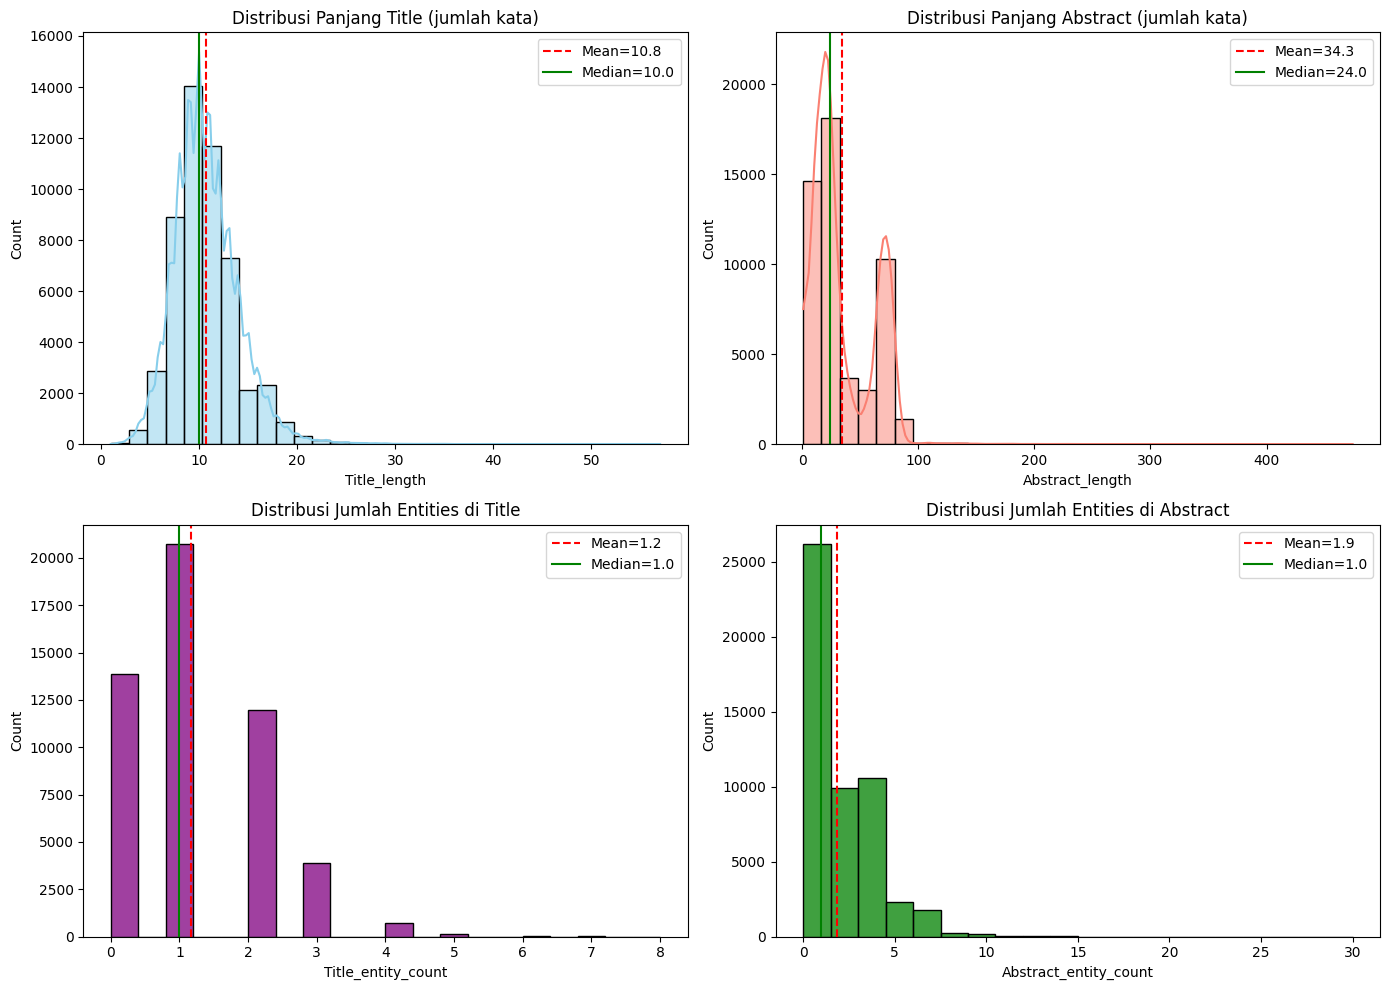

In [17]:
# --- Hitung panjang teks (jumlah kata) ---
df_news["Title_length"] = df_news["Title"].apply(lambda x: len(str(x).split()))
df_news["Abstract_length"] = df_news["Abstract"].apply(lambda x: len(str(x).split()))

# --- Hitung jumlah entities ---
def count_entities(x):
    try:
        entities = ast.literal_eval(str(x))
        return len(entities) if isinstance(entities, list) else 0
    except:
        return 0

df_news["Title_entity_count"] = df_news["Title_Entities"].apply(count_entities)
df_news["Abstract_entity_count"] = df_news["Abstract_Entities"].apply(count_entities)

# --- Buat grid plot 2x2 ---
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.histplot(df_news["Title_length"], bins=30, ax=axes[0,0], color="skyblue", kde=True)
axes[0,0].axvline(df_news["Title_length"].mean(), color='red', linestyle='--', label=f'Mean={df_news["Title_length"].mean():.1f}')
axes[0,0].axvline(df_news["Title_length"].median(), color='green', linestyle='-', label=f'Median={df_news["Title_length"].median():.1f}')
axes[0,0].legend()
axes[0,0].set_title("Distribusi Panjang Title (jumlah kata)")

sns.histplot(df_news["Abstract_length"], bins=30, ax=axes[0,1], color="salmon", kde=True)
axes[0,1].axvline(df_news["Abstract_length"].mean(), color='red', linestyle='--', label=f'Mean={df_news["Abstract_length"].mean():.1f}')
axes[0,1].axvline(df_news["Abstract_length"].median(), color='green', linestyle='-', label=f'Median={df_news["Abstract_length"].median():.1f}')
axes[0,1].legend()
axes[0,1].set_title("Distribusi Panjang Abstract (jumlah kata)")

sns.histplot(df_news["Title_entity_count"], bins=20, ax=axes[1,0], color="purple")
axes[1,0].axvline(df_news["Title_entity_count"].mean(), color='red', linestyle='--', label=f'Mean={df_news["Title_entity_count"].mean():.1f}')
axes[1,0].axvline(df_news["Title_entity_count"].median(), color='green', linestyle='-', label=f'Median={df_news["Title_entity_count"].median():.1f}')
axes[1,0].legend()
axes[1,0].set_title("Distribusi Jumlah Entities di Title")

sns.histplot(df_news["Abstract_entity_count"], bins=20, ax=axes[1,1], color="green")
axes[1,1].axvline(df_news["Abstract_entity_count"].mean(), color='red', linestyle='--', label=f'Mean={df_news["Abstract_entity_count"].mean():.1f}')
axes[1,1].axvline(df_news["Abstract_entity_count"].median(), color='green', linestyle='-', label=f'Median={df_news["Abstract_entity_count"].median():.1f}')
axes[1,1].legend()
axes[1,1].set_title("Distribusi Jumlah Entities di Abstract")

plt.tight_layout()
plt.savefig('distribusi_univariate1.png')
plt.show()

Pada kolom teks, **distribusi panjang Title relatif konsisten dengan rata-rata 10 kata**, menunjukkan judul berita umumnya singkat dan padat. **Abstract memiliki distribusi yang lebih bervariasi dengan rata-rata 34 kata**, namun median 24 kata, menandakan adanya beberapa abstrak yang sangat panjang sehingga memengaruhi rata-rata.

Untuk entity **extraction, judul umumnya hanya memuat sekitar 1 entitas (mean 1.2, median 1)**, **sedangkan abstrak lebih kaya entitas dengan rata-rata 1.9 dan median 1**. Distribusi keduanya cenderung miring ke kanan (right-skewed), artinya sebagian besar teks mengandung sedikit entitas, namun terdapat outlier dengan jumlah entitas yang jauh lebih banyak.

### Multivariate Analysis
Analisis multivariat dilakukan untuk melihat hubungan antara dua atau lebih fitur dalam dataset. Beberapa analisis yang relevan:
* Title_length vs Abstract_length (Scatterplot) --> melihat apakah judul panjang biasanya punya abstrak yang panjang juga.
* Entity Count: Title vs Abstract (Scatterplot) --> melihat apakah jumlah entitas di judul berhubungan dengan jumlah entitas di abstrak.
* Category vs SubCategory → melihat distribusi subkategori di dalam masing-masing kategori. Misalnya apakah kategori Sports didominasi oleh subkategori football_nfl.
* Category vs Panjang Title/Abstract → apakah berita di kategori tertentu cenderung memiliki judul/abstrak yang lebih panjang atau pendek.
* Category vs Jumlah entitas (Title_Entities, Abstract_Entities) → mengecek apakah ada kategori yang lebih kaya entitas, misalnya Politics dengan banyak nama orang/organisasi.
* Pairplot (Grid semua fitur numerik) --> 🔎 Gambaran umum hubungan antar semua fitur numerik.

Title_length vs Abstract_length (Scatterplot) --> 🔎 Apakah judul panjang biasanya punya abstrak yang panjang juga.

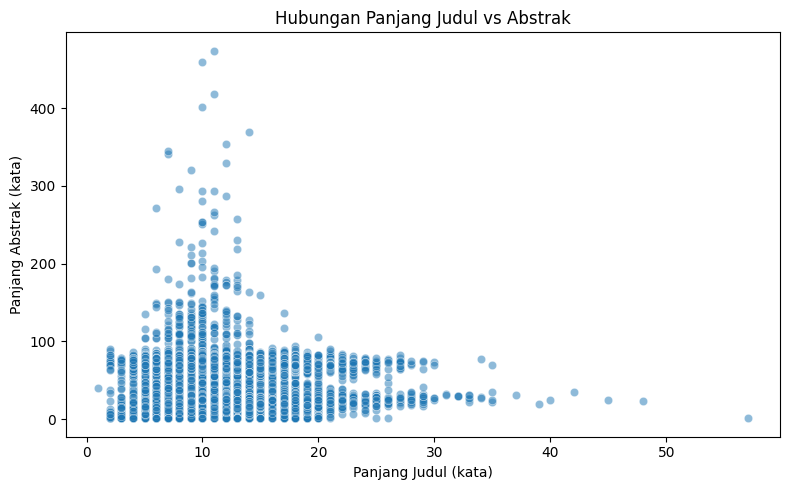

In [18]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_news, x='Title_length', y='Abstract_length', alpha=0.5)
plt.title('Hubungan Panjang Judul vs Abstrak')
plt.xlabel('Panjang Judul (kata)')
plt.ylabel('Panjang Abstrak (kata)')
plt.tight_layout()
plt.savefig('distribusi_multivariate4.png')
plt.show()

Secara keseluruhan, grafik ini menunjukkan bahwa meskipun tidak ada hubungan yang kuat antara panjang judul dan abstrak, sebagian besar dokumen memiliki judul yang relatif pendek dan abstrak yang panjangnya cukup bervariasi, namun terkonsentrasi di kisaran tertentu.

* **Panjang Judul**: Rata-rata kisaran 10 hingga 15 kata.

* **Panjang Abstrak**: Rata-rata terkonsentrasi di kisaran 50 hingga 150 kata.

Mengingat bahwa judul sangat singkat dan abstrak lebih informatif (seperti yang ditunjukkan oleh grafik), menggabungkan kedua teks tersebut adalah strategi yang paling efektif untuk memastikan bahwa model rekomendasi memiliki pemahaman yang paling lengkap tentang setiap artikel.

Entity Count: Title vs Abstract (Scatterplot) --> 🔎 Apakah jumlah entitas di judul berhubungan dengan jumlah entitas di abstrak.

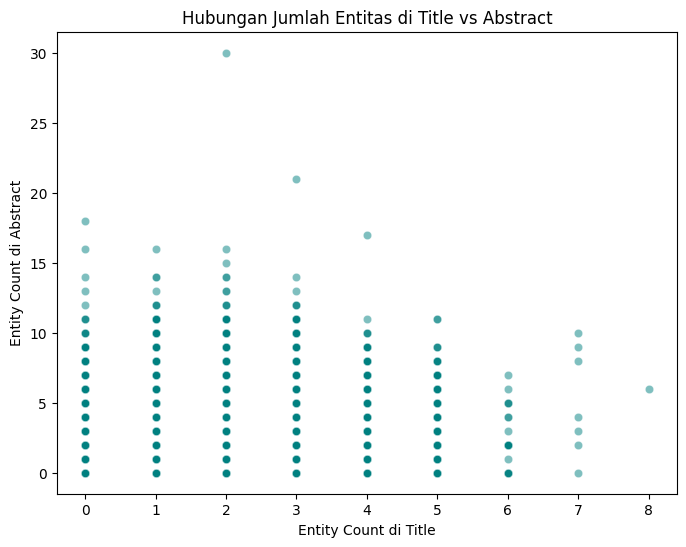

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_news, x="Title_entity_count", y="Abstract_entity_count", alpha=0.5, color="teal")
plt.title("Hubungan Jumlah Entitas di Title vs Abstract")
plt.xlabel("Entity Count di Title")
plt.ylabel("Entity Count di Abstract")
plt.savefig('distribusi_multivariate5.png')
plt.show()

Secara keseluruhan, grafik ini menyimpulkan bahwa tidak ada hubungan langsung antara jumlah entitas di judul dan jumlah entitas di abstrak. Judul cenderung memiliki jumlah entitas yang sangat sedikit, sementara abstrak dapat berisi jumlah entitas yang jauh lebih banyak dan bervariasi.

* Jumlah Entitas di Judul (Title): antara 0 hingga 3 entitas. Konsentrasi titik data terbesar berada di kolom 0, 1, 2, dan 3 di sumbu horizontal (sumbu x).

* Jumlah Entitas di Abstrak: Jumlah entitas di abstrak memiliki variasi yang jauh lebih besar, dari 0 hingga 30. Ini menunjukkan bahwa abstrak cenderung lebih kaya akan entitas daripada judul.

* Pola Sebaran: Meskipun jumlah entitas di judul rendah, jumlah entitas di abstrak bisa bervariasi dari sangat rendah hingga sangat tinggi.

Category vs SubCategory (Heatmap) -->
🔎 Melihat distribusi subkategori pada tiap kategori berita.

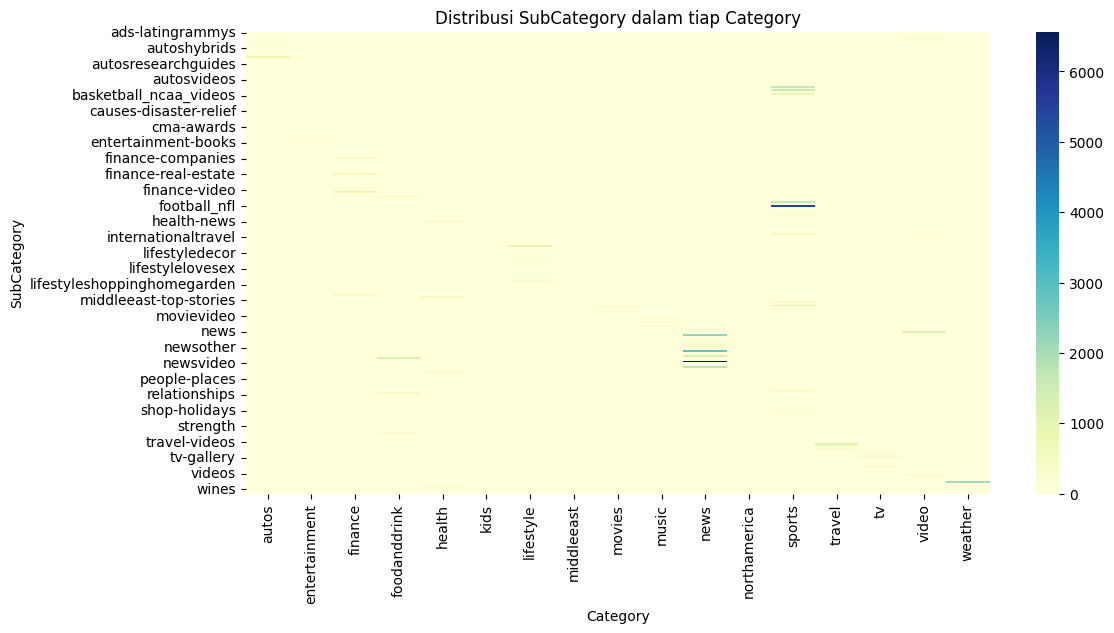

In [20]:
crosstab = pd.crosstab(df_news['SubCategory'], df_news['Category'])
plt.figure(figsize=(12,6))
sns.heatmap(crosstab, cmap="YlGnBu", cbar=True)
plt.title("Distribusi SubCategory dalam tiap Category")
plt.ylabel("SubCategory")
plt.xlabel("Category")
plt.savefig('distribusi_multivariate.png')
plt.show()

Analisis eksploratif menunjukkan bahwa kategori News dan TV memiliki judul yang cenderung lebih panjang (median tinggi), sedangkan Kids, Middle East, dan North America menunjukkan judul paling singkat. Untuk panjang abstrak, Movies, Weather, dan News menonjol dengan median dan rentang yang besar, termasuk sejumlah outlier eksternal mengindikasikan konten yang lebih panjang atau lebih mendalam pada kategori tersebut

Category vs Panjang Title/Abstract → 🔎 Apakah berita di kategori tertentu cenderung memiliki judul/abstrak yang lebih panjang atau pendek.

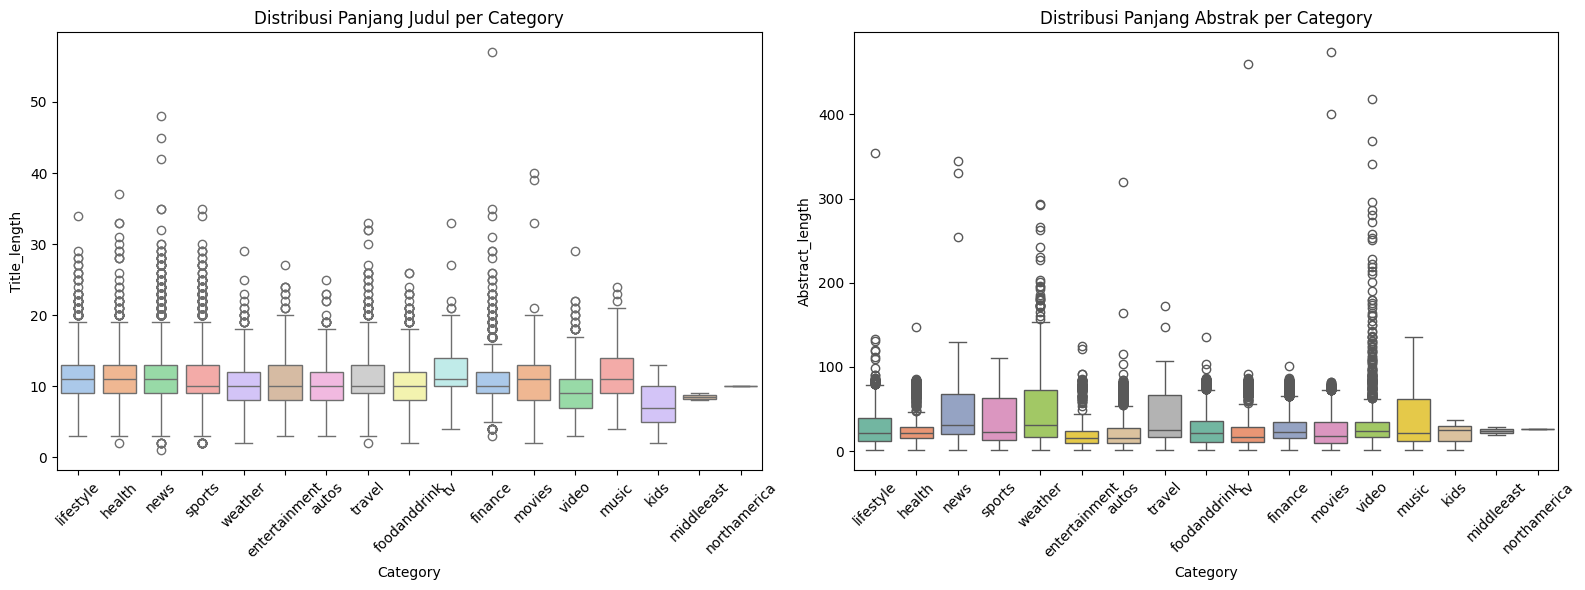

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Boxplot Title Length
sns.boxplot(data=df_news, x="Category", hue= "Category", y="Title_length", palette="pastel", ax=axes[0])
axes[0].set_title("Distribusi Panjang Judul per Category")
axes[0].tick_params(axis='x', rotation=45)

# Boxplot Abstract Length
sns.boxplot(data=df_news, x="Category", hue= "Category", y="Abstract_length", palette="Set2", ax=axes[1])
axes[1].set_title("Distribusi Panjang Abstrak per Category")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('distribusi_multivariate1.png')
plt.show()

Distribusi Panjang Judul (Title_length) per Kategori
* Kategori TV dan News cenderung memiliki judul yang lebih panjang dibanding kategori lain, terlihat dari median dan beberapa outlier yang cukup tinggi.
* Kategori seperti Kids, Middle East, dan North America cenderung memiliki judul paling pendek.

Distribusi Panjang Abstrak (Abstract_length) per Kategori
* Kategori Movies, Weather, dan News memiliki abstrak yang lebih panjang secara umum, dengan beberapa outlier ekstrem.
* Kategori Kids, Middle East, dan North America tetap cenderung memiliki abstrak paling pendek.

Category vs Entity Counts (Boxplot) --> 🔎 Perbedaan jumlah entitas antar kategori.

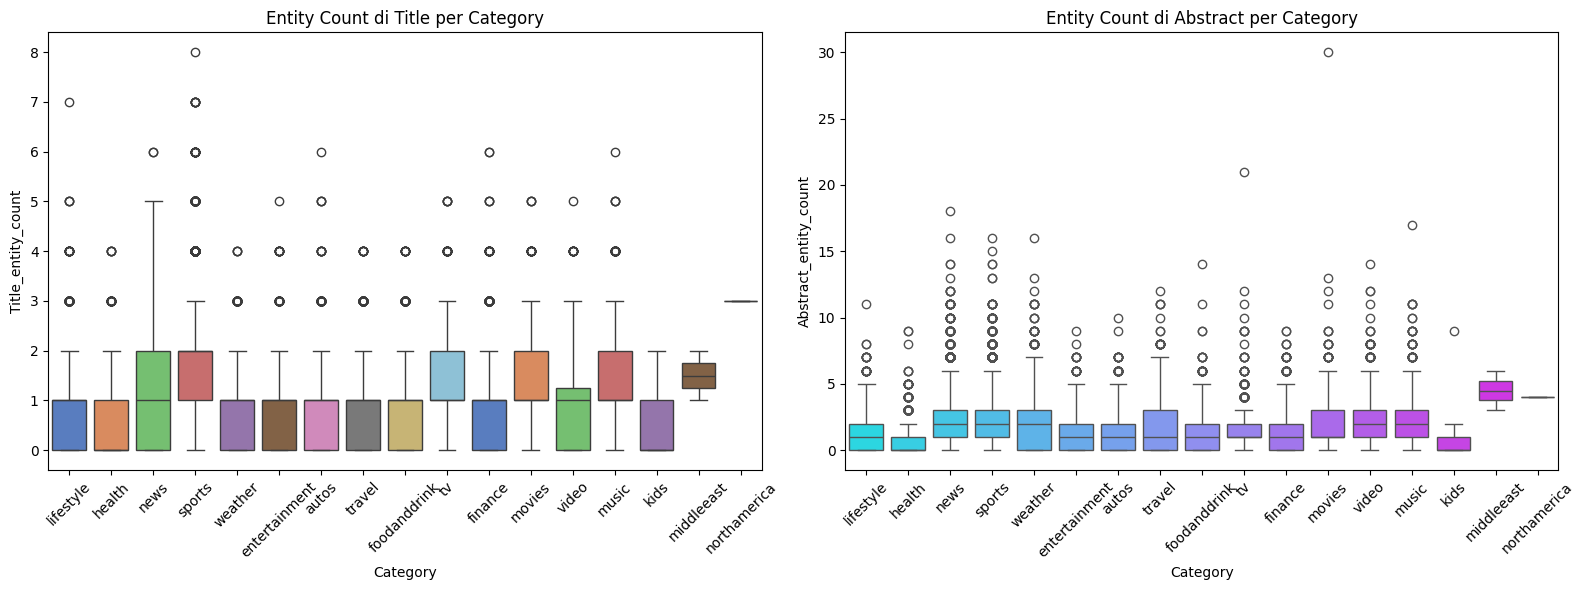

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
sns.boxplot(data=df_news, x="Category", hue = "Category", y="Title_entity_count", ax=axes[0], palette="muted")
axes[0].set_title("Entity Count di Title per Category")
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(data=df_news, x="Category", hue = "Category", y="Abstract_entity_count", ax=axes[1], palette="cool")
axes[1].set_title("Entity Count di Abstract per Category")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('distribusi_multivariate2.png')
plt.show()

* Jumlah entitas bisa menjadi indikator untuk membedakan kategori.
* Artikel berita dan olahraga memiliki jumlah entitas yang jauh lebih beragam dan tinggi dibanding kategori hiburan.
* Kategori Middle East secara konsisten kaya entitas, baik di judul maupun abstrak.
* Sebaliknya, kategori hiburan (Movies, Music, Lifestyle, Kids) cenderung miskin entitas.

Pairplot (Grid semua fitur numerik) --> 🔎 Gambaran umum hubungan antar semua fitur numerik.

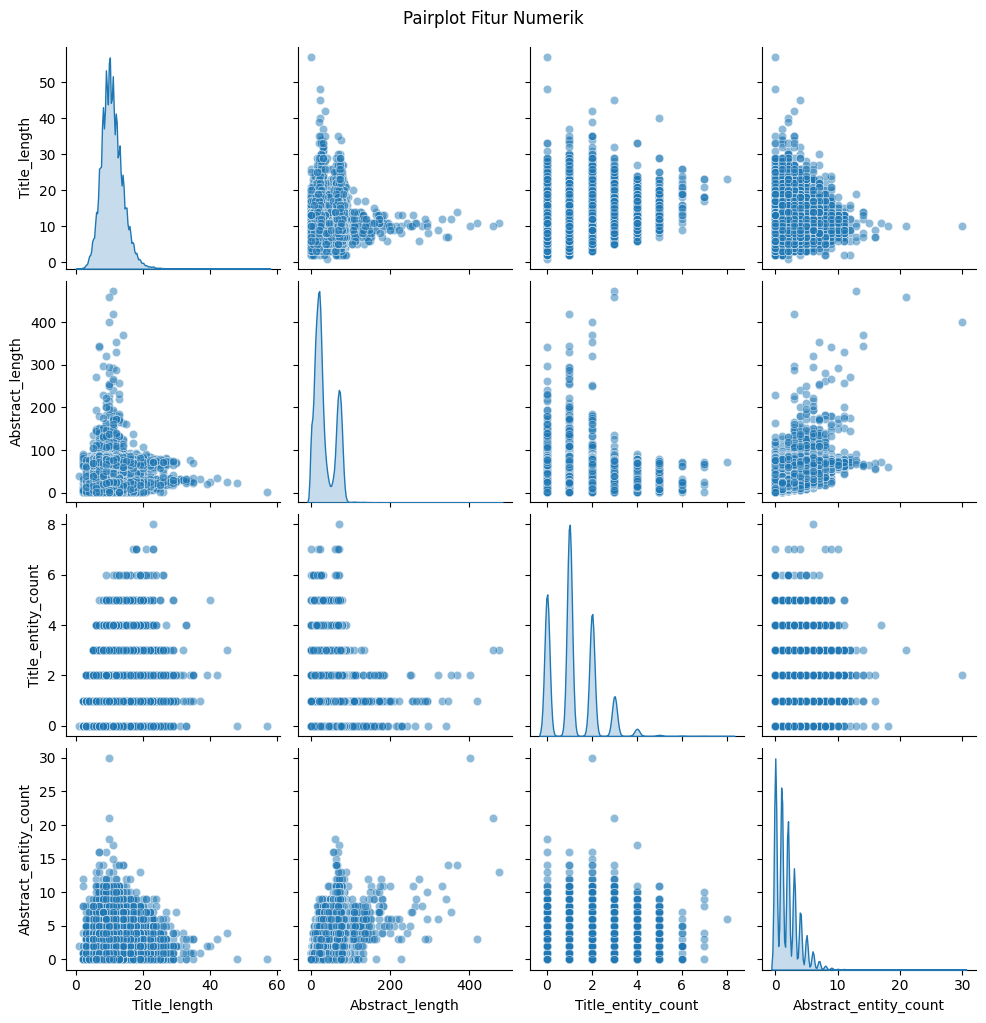

In [23]:
num_cols = ["Title_length", "Abstract_length", "Title_entity_count", "Abstract_entity_count"]

sns.pairplot(df_news[num_cols], diag_kind="kde", plot_kws={'alpha':0.5})
plt.suptitle("Pairplot Fitur Numerik", y=1.02)
plt.savefig('distribusi_multivariate3.png')
plt.show()

Hasil visualisasi pairplot menunjukkan bahwa fitur numerik dalam dataset memiliki beberapa pola hubungan. Distribusi panjang judul (Title_length) relatif sempit, mayoritas berada di kisaran 5–15 kata, sedangkan panjang abstrak (Abstract_length) lebih bervariasi dengan rentang yang lebar hingga di atas 200 kata. Jumlah entitas pada judul (Title_entity_count) sebagian besar hanya 0–2, sedangkan pada abstrak (Abstract_entity_count) lebih banyak dan bisa mencapai lebih dari 20.

Dari hubungan antar fitur, terlihat bahwa panjang abstrak memiliki korelasi positif dengan jumlah entitas pada abstrak, yang berarti semakin panjang abstrak maka semakin kaya informasi yang terkandung di dalamnya. Hubungan serupa juga muncul antara jumlah entitas pada judul dengan entitas pada abstrak. Sebaliknya, panjang judul dan panjang abstrak hanya menunjukkan hubungan yang lemah. Secara umum, abstrak lebih representatif dalam memuat informasi dibandingkan judul, baik dari segi panjang teks maupun keberagaman entitas.

## Dataset Preprocessing
After doing some analysis, we will do data preparation like removing null values, duplicates, and outliers. We also will normalize the feature to make them have equall weights for the ML models.

> News


In [24]:
news_clean = df_news.copy()

In [25]:
news_clean.shape

(51282, 12)

In [26]:
# Menghitung jumlah nilai kosong di setiap kolom
missing_values = news_clean.isna().sum()
print(missing_values[missing_values > 0])

Abstract             2666
Title_Entities          3
Abstract_Entities       4
dtype: int64


In [27]:
news_clean = news_clean.dropna()
news_clean.drop_duplicates(subset=['News_ID'], inplace=True)

In [28]:
news_clean.shape

(48612, 12)

> Behaviors

In [29]:
behaviors_clean = df_behaviors.copy()

In [30]:
behaviors_clean.shape

(156965, 5)

In [31]:
# Menghitung jumlah nilai kosong di setiap kolom
missing_values_behaviors = behaviors_clean.isna().sum()
print(missing_values_behaviors[missing_values_behaviors > 0])

History    3238
dtype: int64


In [32]:
behaviors_clean = behaviors_clean.dropna()
behaviors_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)

In [33]:
behaviors_clean.shape

(153727, 5)

## Feature Engineering
setelah melakukan data preprocessing data lanjut ke tahap ini fimana akan mengubah data menjadi fitur yang lebih representatif dan relevan untuk model

### Tabel Behaviors User
Tabel Behaviors User berisi interaksi pengguna dengan berita, misalnya apakah artikel diklik atau tidak. Data ini berfungsi sebagai label perilaku user untuk evaluasi sistem rekomendasi, membantu menilai relevansi prediksi terhadap preferensi nyata pengguna.

In [34]:
interactions = []

for _, row in behaviors_clean.iterrows():
    user_id = row['User_ID']
    impressions = row['Impressions'].split()

    for imp in impressions:
        news_id, label = imp.split('-')
        label = int(label)
        interactions.append([user_id, news_id, label])

behaviors_user = pd.DataFrame(interactions, columns=['User_ID', 'News_ID', 'Label'])

In [35]:
behaviors_user.groupby('Label')['Label'].value_counts()

,count
Label,
0,5491472
1,231530


### Tabel Full Text
Supaya model dapat menangkap kata kunci dan konteks artikel yang lebih lengkap dan lebih kaya kolum title dan abstract sebaiknya digabung menjadi kolum baru yaitu full text

In [36]:
# Menggabungkan Title dan Abstract ke kolom baru 'TitleAbstract'
news_clean['Full_Text'] = news_clean['Title'] + " " + news_clean['Abstract']

In [37]:
# Menampilkan 5 baris pertama dari kolom baru untuk verifikasi
news_clean[['Title', 'Abstract', 'Full_Text']].head()

,Title,Abstract,Full_Text
0,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...","The Brands Queen Elizabeth, Prince Charles, an..."
1,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,50 Worst Habits For Belly Fat These seemingly ...
2,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,The Cost of Trump's Aid Freeze in the Trenches...
3,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",I Was An NBA Wife. Here's How It Affected My M...
4,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...","How to Get Rid of Skin Tags, According to a De..."


### Pra-pemrosesan Teks
Tahap ini bertujuan untuk membersihkan teks pada kolom Full_Text agar siap digunakan untuk analisis.

In [38]:
# Mengambil daftar stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))

# Inisialisasi Porter Stemmer
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tahap 1: Case Folding
    text = text.lower()

    # Tahap 2: Punctuation Removal
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Tahap 3: Tokenisasi dan Stopword Removal
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Tahap 4: Stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    # Gabungkan kembali token yang sudah di-stem menjadi string
    return ' '.join(stemmed_tokens)

# Terapkan fungsi pra-pemrosesan ke kolom 'Full_Text'
news_clean['Cleaned_Text'] = news_clean['Full_Text'].apply(preprocess_text)

In [39]:
# Menampilkan 5 baris pertama dari kolom baru untuk verifikasi
news_clean['Cleaned_Text'].iloc[1]

'50 worst habit belli fat seemingli harmless habit hold back keep shed unwant belli fat good'

### Representasi Teks ke Vektor
Setelah Anda berhasil melakukan pra-pemrosesan teks pada kolom Full_Text dan mendapatkan kolom baru Cleaned_Text, langkah berikutnya adalah Representasi Teks ke Vektor. Ini adalah tahap mengubah teks yang sudah bersih menjadi angka.

In [108]:
# Inisialisasi TfidfVectorizer
# min_df=5 akan mengabaikan kata yang muncul di kurang dari 5 dokumen.
# Ini membantu mengurangi dimensi matriks dan menghilangkan kata-kata yang tidak relevan.
tfidf_vectorizer = TfidfVectorizer(min_df=5,stop_words='english')

# Terapkan vectorizer ke kolom 'Cleaned_Text'
tfidf_matrix = tfidf_vectorizer.fit_transform(news_clean['Cleaned_Text'])

# tfidf_matrix adalah matriks yang berisi vektor TF-IDF untuk setiap artikel.
# Bentuk (shape) matriks ini adalah (jumlah_artikel, jumlah_kata_unik).
print("Bentuk matriks TF-IDF:", tfidf_matrix.shape)

Bentuk matriks TF-IDF: (48612, 14148)


## Modelling
Setelah mengubah teks menjadi vektor diperlukan melakukan modelling dengan nearest neighbors

In [109]:
# Inisialisasi model NearestNeighbors
# n_neighbors=11 karena kita akan mengambil 10 rekomendasi (artikel itu sendiri juga dihitung)
model_nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)

# Latih model dengan matriks TF-IDF
model_nn.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

In [110]:
# Simpan TF-IDF Vectorizer
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

# Simpan Model NearestNeighbors
joblib.dump(model_nn, "nearest_neighbors_model.pkl")

['nearest_neighbors_model.pkl']

## Evaluasi
tahap ini bertujuan mengukur seberapa baik sistem rekomendasi content-based filtering memprediksi minat user berdasarkan history klik/impression dengan menggunakan metrik precision dan recall

In [136]:
# Buat mapping News_ID → index
news_index_map = pd.Series(news_clean.index, index=news_clean['News_ID']).to_dict()

# Fungsi rekomendasi setiap berita
def get_recommendations(news_id, top_n=5):
    # Ambil data berita utama
    news = news_clean.loc[news_index_map[news_id]]
    print("---Rekomendasi Untuk Berita---")
    print(f"News_ID: {news['News_ID']}, Title: {news['Title']}, Category: {news['Category']}")

    print("\n---Hasil Top 10 Rekomendasi Berita---")
    # Ambil vector TF-IDF berita
    news_vector = tfidf_matrix[news_index_map[news_id]]

    # Cari tetangga terdekat
    distances, neighbor_indices = model_nn.kneighbors(news_vector, n_neighbors=top_n+1)

    # Ambil rekomendasi (skip berita utama sendiri)
    rekom_indices = neighbor_indices[0][1:]
    rekom = news_clean.iloc[rekom_indices].copy()

    # Hitung similarity
    rekom['Similarity'] = 1 - distances[0][1:]

    return rekom[['News_ID','Title','Category','Similarity']]

In [137]:
# Cek hasil rekomendasi top 10 salah satu news
get_recommendations("N58133", top_n=10)

---Rekomendasi Untuk Berita---
News_ID: N58133, Title: George Kent, top State Department Ukraine expert, helps Democrats debunk GOP theories, Category: news

---Hasil Top 10 Rekomendasi Berita---


,News_ID,Title,Category,Similarity
44474,N21750,Watch: Coach P.J. Fleck crowd surfs in locker ...,sports,0.474416
12298,N57845,P.J. Fleck says Minnesota didn't avoid night g...,sports,0.424330
14510,N12108,Fleck: Saturday vs. Penn State 'one of the big...,sports,0.405241
42581,N61255,No. 13 Minnesota stays unbeaten by taking down...,sports,0.399596
25126,N21237,P.J. Fleck signs extension with Minnesota amid...,sports,0.396706
20551,N32537,P.J. Fleck signs extension with Minnesota amid...,sports,0.396706
40871,N34871,Watch: Fleck crowd surfs in locker room after ...,sports,0.385796
27576,N49931,Gophers Go 8-0 After Star Tribune Columnist Ca...,sports,0.380333
49027,N16984,"Iowa a tough place to visit, and not just for ...",sports,0.342086
41871,N41487,Minnesota Golden Gophers remain undefeated bea...,sports,0.316202


In [138]:
# 1. Merge behaviors user dengan news_clean untuk dapat kolom Category
interaksi_merged = behaviors_user.merge(
    news_clean[['News_ID', 'Category']],
    on='News_ID',
    how='left'
)

# 2. Filter hanya klik positif (Label==1)
behaviors_pos = interaksi_merged[interaksi_merged['Label'] == 1]
# Hapus baris yang Category = NaN
behaviors_pos = behaviors_pos.dropna(subset=['Category'])

# 3. Group by User_ID dan ambil set kategori
category_user = behaviors_pos.groupby('User_ID')['Category'].apply(set).to_dict()

In [139]:
# Cek category yang pernah user klik
category_user.get("U91836", "User tidak ditemukan")

{'finance', 'foodanddrink', 'lifestyle', 'news', 'travel', 'video'}

In [140]:
def evaluate_user(last_news, user_id, news_df, category_user_map, k=5, show_rekom=True):
    category_user_set = category_user_map.get(user_id, set())
    if not category_user_set:
        return {"precision": 0.0, "recall": 0.0}

    print("UserId :", user_id)
    # Ambil rekomendasi
    rekom = get_recommendations(last_news, top_n=k)

    if show_rekom:  # kalau mau tampilkan tabel rekomendasi
        display(rekom)

    predicted_news_ids = rekom['News_ID'].values
    category_prediction = news_df.loc[
        news_df['News_ID'].isin(predicted_news_ids[:k]), 'Category'
    ]

    # Precision = jumlah artikel relevan / total artikel rekomendasi
    hits = sum([1 for kategori in category_prediction if kategori in category_user_set])
    precision = hits / k

    # Recall = jumlah kategori relevan yang muncul / total kategori user
    categories_in_prediction = set(category_prediction)
    relevant_categories = categories_in_prediction.intersection(category_user_set)
    recall = len(relevant_categories) / len(category_user_set)

    return {"precision": precision, "recall": recall}

In [142]:
user_id = "U13740"
last_news = "N58133"
k = 10

metrics = evaluate_user(last_news, user_id, news_clean, category_user, k=k, show_rekom=True)
print(f"\nUser: {user_id}, Precision@{k}: {metrics['precision']:.2f}, Recall@{k}: {metrics['recall']:.2f}")

UserId : U13740
---Rekomendasi Untuk Berita---
News_ID: N58133, Title: George Kent, top State Department Ukraine expert, helps Democrats debunk GOP theories, Category: news

---Hasil Top 10 Rekomendasi Berita---


,News_ID,Title,Category,Similarity
44474,N21750,Watch: Coach P.J. Fleck crowd surfs in locker ...,sports,0.474416
12298,N57845,P.J. Fleck says Minnesota didn't avoid night g...,sports,0.424330
14510,N12108,Fleck: Saturday vs. Penn State 'one of the big...,sports,0.405241
42581,N61255,No. 13 Minnesota stays unbeaten by taking down...,sports,0.399596
25126,N21237,P.J. Fleck signs extension with Minnesota amid...,sports,0.396706
20551,N32537,P.J. Fleck signs extension with Minnesota amid...,sports,0.396706
40871,N34871,Watch: Fleck crowd surfs in locker room after ...,sports,0.385796
27576,N49931,Gophers Go 8-0 After Star Tribune Columnist Ca...,sports,0.380333
49027,N16984,"Iowa a tough place to visit, and not just for ...",sports,0.342086
41871,N41487,Minnesota Golden Gophers remain undefeated bea...,sports,0.316202



User: U13740, Precision@10: 1.00, Recall@10: 0.33


In [143]:
# --- Fungsi CBF Precision & Recall versi batch ---
def cbf_eval(k=5, n_samples=100, return_per_user=False):
    total_prec = 0
    total_recall = 0
    count = 0

    user_sample = behaviors_user['User_ID'].unique()[:n_samples]  # Subset user
    per_user_scores = []

    for user_id in user_sample:
        if user_id not in category_user:
            continue

        # Cari berita terakhir yang diklik user
        news_user = behaviors_user[
            (behaviors_user['User_ID'] == user_id) &
            (behaviors_user['Label'] == 1)
        ]
        news_user = news_user[news_user['News_ID'].isin(news_index_map.keys())]
        last_news = news_user['News_ID'].values[-1] if not news_user.empty else None

        if last_news:
            try:
                # Hitung precision & recall user ini
                metrics = evaluate_user(last_news, user_id, news_clean, category_user, k=k, show_rekom=False)
                total_prec += metrics['precision']
                total_recall += metrics['recall']
                count += 1

                per_user_scores.append((user_id, metrics['precision'], metrics['recall']))
            except:
                continue

    avg_prec = total_prec / count if count > 0 else 0.0
    avg_recall = total_recall / count if count > 0 else 0.0

    if return_per_user:
        return (avg_prec, avg_recall), per_user_scores
    return avg_prec, avg_recall

In [144]:
(avg_prec, avg_recall), per_user_scores = cbf_eval(k=10, n_samples=50, return_per_user=True)

UserId : U13740
---Rekomendasi Untuk Berita---
News_ID: N58133, Title: George Kent, top State Department Ukraine expert, helps Democrats debunk GOP theories, Category: news

---Hasil Top 10 Rekomendasi Berita---
UserId : U91836
---Rekomendasi Untuk Berita---
News_ID: N56117, Title: Multistate police pursuit ends on Cane Run Road, Category: news

---Hasil Top 10 Rekomendasi Berita---
UserId : U73700
---Rekomendasi Untuk Berita---
News_ID: N34117, Title: 49ers: Joe Staley could miss time with new injury; Ronald Blair out for season, Category: sports

---Hasil Top 10 Rekomendasi Berita---
UserId : U34670
---Rekomendasi Untuk Berita---
News_ID: N62360, Title: The son of a Chinese billionaire has been banned from flying first class, playing golf, buying property, or going clubbing, Category: news

---Hasil Top 10 Rekomendasi Berita---
UserId : U8125
---Rekomendasi Untuk Berita---
News_ID: N8400, Title: These are the new cars that depreciate least, Category: autos

---Hasil Top 10 Rekomendas

> Hasil rata rata dan 5 user pertama

In [135]:
print(f"Rata-rata Precision@10: {avg_prec:.2f}")
print(f"Rata-rata Recall@10   : {avg_recall:.2f}")

# contoh lihat 5 user pertama
print("\nTop 5 user pertama")
for u, p, r in per_user_scores[:10]:
    print(f"User: {u}, Precision: {p:.2f}, Recall: {r:.2f}")

Rata-rata Precision@10: 0.49
Rata-rata Recall@10   : 0.28

Top 5 user pertama
User: U13740, Precision: 1.00, Recall: 0.33
User: U91836, Precision: 0.00, Recall: 0.00
User: U73700, Precision: 0.40, Recall: 0.50
User: U8125, Precision: 0.00, Recall: 0.00
User: U8355, Precision: 0.00, Recall: 0.00
User: U46596, Precision: 0.80, Recall: 0.75
User: U53231, Precision: 0.90, Recall: 0.33
User: U89744, Precision: 0.60, Recall: 0.12
User: U92486, Precision: 1.00, Recall: 0.25
User: U29155, Precision: 0.80, Recall: 0.18


> Hasil Visualisasi

In [146]:
df_eval = pd.DataFrame(per_user_scores, columns=['User_ID','Precision@10','Recall@10'])
# Ubah df_eval jadi long format biar bisa langsung dipakai seaborn
df_melt = df_eval.melt(id_vars='User_ID', value_vars=['Precision@10','Recall@10'],
                       var_name='Metric', value_name='Score')

avg_values = df_eval[['Precision@10','Recall@10']].mean()
metrics = ['Precision', 'Recall']
values = [avg_values['Precision@10'], avg_values['Recall@10']]

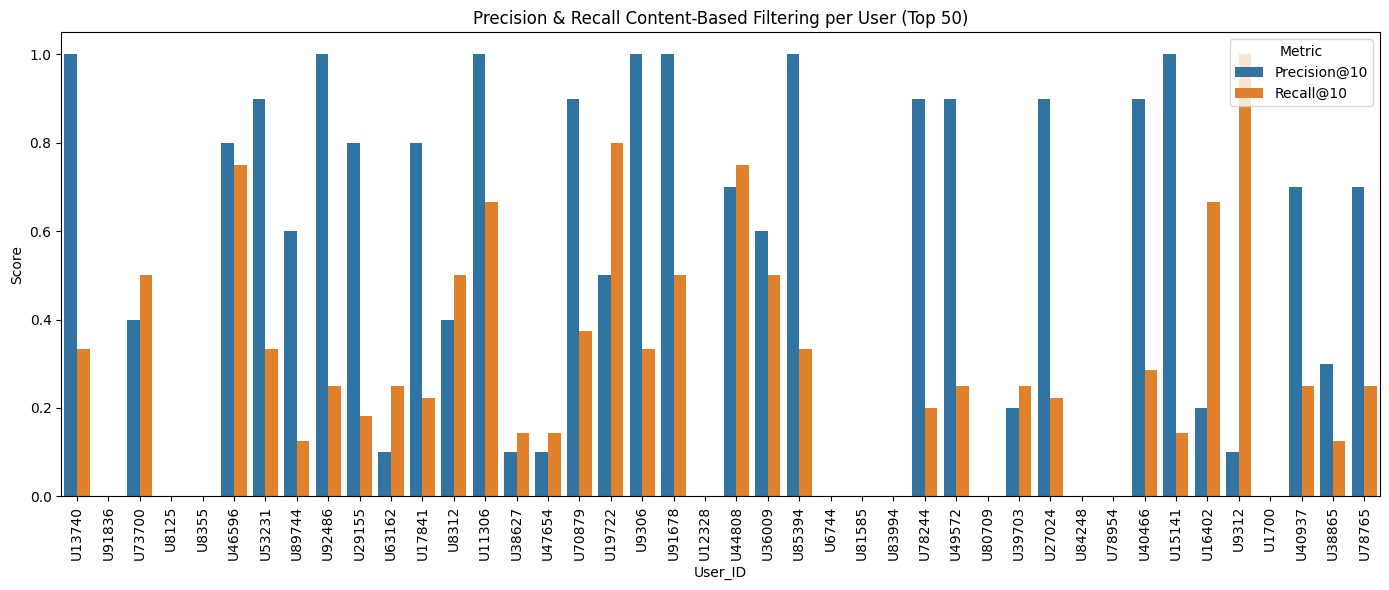

In [147]:
plt.figure(figsize=(14,6))
sns.barplot(x='User_ID', y='Score', hue='Metric', data=df_melt)

plt.xticks(rotation=90)
plt.title('Precision & Recall Content-Based Filtering per User (Top 50)')
plt.ylabel('Score')
plt.xlabel('User_ID')
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig('user_bar_chart.png')
plt.show()

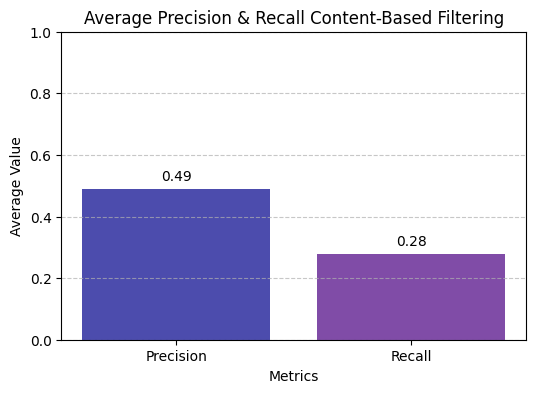

In [148]:
plt.figure(figsize=(6,4))
bars = plt.bar(metrics, values, color=['darkblue','indigo'], alpha=0.7)

# Tambahkan nilai di atas bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}',
             ha='center', va='bottom', fontsize=10)

plt.title('Average Precision & Recall Content-Based Filtering', fontsize=12)
plt.xlabel('Metrics', fontsize=10)
plt.ylabel('Average Value', fontsize=10)
plt.ylim(0,1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('average_metrics_bar_chart.png')
plt.show()

**Dari top-50 user:**

1. **Content-based Precision@10 = 0.49** → setengah rekomendasi sesuai dengan kategori yang pernah diklik.
2. **Content-based Recall@10 = 0.28**→ hanya 28% kategori user tercakup di top-10 rekomendasi.

**Interpretasi:** sistem cenderung fokus pada konten mirip last clicked → akurat tapi belum menutupi seluruh minat user.

## Saran
Tahap ini bertujuan untuk memberikan arahan pengembangan lebih lanjut berdasarkan hasil yang sudah dicapai. Beberapa hal yang bisa dilakukan ke depannya antara lain:

1. Perbaikan Data
- Pastikan data berita memiliki kategori lengkap agar tidak ada NaN yang hilang saat pemrosesan.
- Lakukan normalisasi pada teks agar lebih konsisten (misalnya menggabungkan sinonim atau memperbaiki typo).
2. Pengembangan Model
- Coba kurangi dimensi TF-IDF dengan max_features atau metode seperti TruncatedSVD (LSA) untuk efisiensi.
- Bandingkan kinerja dengan model lain seperti Word2Vec, Doc2Vec, atau Transformer embeddings (misal BERT).
3. Evaluasi yang Lebih Komprehensif
- Tambahkan metrik evaluasi lain seperti Recall@K, F1-score, atau MRR (Mean Reciprocal Rank).
- Lakukan evaluasi per kategori berita untuk melihat apakah sistem adil terhadap semua kategori.
4. Personalization
- Kembangkan pendekatan hybrid recommendation dengan menggabungkan content-based filtering (TF-IDF) dan collaborative filtering.
- Pertimbangkan faktor waktu (recency) karena berita cepat kadaluarsa.